# Проект: телекоммуникации

# Описание проекта

Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.  
Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.  

**Цель работы:**  

1) Провести исследовательский анализ данных и составить портрет типичного клиента, который отказался от услуг компании.  

2) Обучить 2-3 различные модели машинного обучения, выбрать лучшую с метрикой roc_auc >= 0.85.  

# Описание услуг
Оператор предоставляет **два основных типа услуг**:   
1) Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.  

2) Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).  

*Также доступны такие услуги:*

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);  
- Выделенная линия технической поддержки (TechSupport);  
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);  
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).  

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

# План работы

**Шаг 1. Загрузка данных**  
Загрузим данные и выполним их первичный осмотр.  

**Шаг 2. Исследовательский анализ и предобработка данных**  
Выполним исследовательский анализ каждого датафрейма и при необходимости выполним предобработку. Выводы об имеющихся признаках: понадобятся ли они для обучения моделей.  

**Шаг 3. Объединение данных и удаление лишних признаков**  .  

**Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма**  
Выполним исследовательский анализ объединённого датафрейма, визуализируем распределения признаков. Проведем корреляционный анализ.  

**Шаг 5. Подготовка данных**  
Разделим данные на две выборки, при масштабировании и кодировании учитывайте особенности данных и моделей

**Шаг 6.Обучение моделей**  
Построим пайплайн с масштабированием и кодированием данных. Проведем кросс-валидацию. Обучим три разные модели.   

**Шаг 7. Тестирование лучшей модели**  
Выберем лучшую модель и проверем её качество на тестовой выборке.  

**Шаг 8. Общий вывод и рекомендации заказчику**

---

# Проект

## 1. Загрузка данных  

Импортируем необходимые библиотеки для дальнейшей работы.

In [1]:
# !pip install phik

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

from catboost import CatBoostClassifier, Pool, cv

Загрузим и изучим все четыре датасета, которые передал нам заказчик, и сохраним в соответствующих переменных.

In [3]:
# датасет с информацией о договорах

try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
except:
    df_contract = pd.read_csv('datasets\contract_new.csv')

In [4]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
df_contract.head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [6]:
# датасет с персональными данными клиента

try:
    df_personal = pd.read_csv('/datasets/personal_new.csv')
except:
    df_personal = pd.read_csv('datasets\personal_new.csv')

In [7]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
# с информацией об интернет-услугах

try:
    df_internet = pd.read_csv('/datasets/internet_new.csv')
except:
    df_internet = pd.read_csv('datasets\internet_new.csv')

In [10]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
# с информацией об услугах телефонии

try:
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    df_phone = pd.read_csv('datasets\phone_new.csv')

In [13]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Наблюдения:**  
1) Пропусков с данных не обнаружено.  

2) Кол-во строк в df_contract и в df_personal совпадает. Предположительно, в них находятся клиенты с одинаковыми id. Нужно будет проверить.  

3) Кол-во строк в df_internet и в df_phone значительно меньше, чем в предыдущих датафреймах. Значит, информация есть на не всех пользователей.

3) В df_contract нужно именить тип данных в след. столбцах:  
- BeginDate привести к date;  
- TotalCharges привести к float;  

4) Во всех остальных колонках во всех данных тип данных совпадает с ожидаемым.  

5) В некоторых колонках yes/no указано в бинарной системе счисления.  

6) Проверим данные на наличие дубликатов.

## 2. Исследовательный анализ и предобработка данных.

**1) Проверим, совпадают ли значения** в колонке *customerID* из датасета df_contract со значениями в одноименной колонке df_personal.

In [15]:
df_personal['customerID'].isin(df_contract['customerID']).value_counts()

True    7043
Name: customerID, dtype: int64

In [16]:
df_contract['customerID'].isin(df_personal['customerID']).value_counts()

True    7043
Name: customerID, dtype: int64

Кол-во совпадающих значений равно кол-ву строк в обоих датафреймах. Значит, все значения совпадают.

**2) Приведем колонку *BeginDate* к типу данных date.**

In [17]:
df_contract.BeginDate = pd.to_datetime(df_contract.BeginDate)

In [18]:
df_contract.BeginDate.dtype

dtype('<M8[ns]')

Также у нас есть вторая колонка частично с датами. Ее мы пока преобразовывать не будем. Далее нам потребуется вычленить из нее целевой признак для предсказаний модели.

**3) Теперь приведем колонку *TotalCharges* к типу float.**  

Если в колонке есть значения, которые мы не можем перевести в числовой тип, то мы их заменим на None, а затем изучим.

In [19]:
df_contract.TotalCharges = pd.to_numeric(df_contract.TotalCharges, errors='coerce')

In [20]:
# Проверим кол-во пропущенных значений в этой колонке
df_contract.TotalCharges.isna().sum()

11

In [21]:
df_contract.query('TotalCharges.isna()')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Наблюдаем закономерность: у всех объектов с пропущенным значением в колонке дата начала контракта - дата выгрузки.  
Можем предположить, что данные не успели подгрузиться, когда происходила выгрузка.  

Удалим эти обекты.

In [22]:
# Удалим строки, где есть пропуски в данной колонке
df_contract = df_contract.dropna(subset='TotalCharges')
df_contract.TotalCharges.isna().sum()

0

In [23]:
# Проверяем тип колонки
df_contract.TotalCharges.dtype

dtype('float64')

**4) Проверим данные на наличие дубликатов**

In [24]:
df_personal.duplicated().sum()

0

In [25]:
df_contract.duplicated().sum()

0

Полные дубликаты не обнаружены.

Остальные датафреймы не нуждаются в предобработке.  
Если в данных имеются аномальные значения, то мы их встретим в полном исследовательском анализе далее.

**Выводы о кол-ве колонок необходимых для обучения моделей:**  

В датасете df_contract имеются колонки с началом контракта и окончанием, если таковое имеется. Колонку с окончанием действия контракта мы будем использовать как целевой признак. Соответственно, после преобразования нам потребуется удалить эту колонку из данных, чтобы не произошло утечки данных.  

Колонка с началом действия контракта сама по себе не несет никакой информации для обучения модели. Чтобы вывести полезную информацию из этих двух колонок без утечки данных, посчитаем длительность контракта. Если данных об его окончании нет, то будем использовать дату выгрузки датасета: 01.02.2020

После объединения датасетов удалим колонку с id клиентов из конечного датасета, потому что эта колонка нам необходима только для соединения данных: для обучения модели в ней нет никакой полезной информации.

Все остальные колонки можно использовать в обучении.  

## 3. Объединение данных и удаление лишних признаков

**1) Создадим новую колонку Target с целевым признаком в датасете df_contract**, исходя из значений в EndDate.  

Для этого создадим фун-ию, которая будет выдавать:  
- '0', если у объекта в колонке EndDate значение 'No';  
- '1', если у объекта другое значение;  

In [26]:
def targetizing(value):
    if value == 'No':
        return 0
    else:
        return 1

In [27]:
# Применяем фун-ию
df_contract['Target'] = df_contract['EndDate'].apply(targetizing)

In [28]:
# Проверяем
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


**2) Приводим столбец EndDate к типу datetime**, заменяя значение 'No' на дату выгрузки данных.

In [29]:
# Заменяем значение
df_contract.EndDate = df_contract.EndDate.replace('No', '2020-02-01')

In [30]:
'No' in  df_contract.EndDate

False

In [31]:
# Приводим к нужному типу данных
df_contract.EndDate = pd.to_datetime(df_contract.EndDate)

In [32]:
df_contract.EndDate.dtype

dtype('<M8[ns]')

**3) Создадим еще один столбец Duration** с длительностью контракта.  
Для этого вычтем из колонки EndDate колонку BeginDate. Не забудем поменять тип данных с timedelta на integer 

In [33]:
df_contract['Duration'] = (df_contract.EndDate - df_contract.BeginDate).dt.days

In [34]:
# Проверяем
display(df_contract.head())
df_contract.Duration.dtype

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


dtype('int64')

**4) Уберем лишние колонки с началом и окончанием контракта**

In [35]:
df_contract = df_contract.drop(['BeginDate', 'EndDate'], axis=1)

In [36]:
# Проверяем
df_contract.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


**5) Объединяем датафреймы**, соединяя их по колонкам

Объединим df_contract и df_personal, соединяя их по значениям колонки customerID

In [37]:
df_full = df_contract.merge(df_personal, on='customerID')

In [38]:
# Проверяем
df_full.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Duration,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No


In [39]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   Target            7032 non-null   int64  
 7   Duration          7032 non-null   int64  
 8   gender            7032 non-null   object 
 9   SeniorCitizen     7032 non-null   int64  
 10  Partner           7032 non-null   object 
 11  Dependents        7032 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 714.2+ KB


Кол-во строк в датасете изменилось.  

Мы соединили датафреймы по одинаковым id клиентов. Значит, все-таки были различающиеся id, и таблица их не включила в себя. Мы потеряли 12 строк - это не слишком много; можем оставить так.

Теперь присоединим к новому датафрейму df_internet и df_phone. Соединяя customerID по первому датафрейму

In [40]:
df_full = df_full.merge(df_internet, on='customerID', how='left')

In [41]:
df_full = df_full.merge(df_phone, on='customerID', how='left')

In [42]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   Target            7032 non-null   int64  
 7   Duration          7032 non-null   int64  
 8   gender            7032 non-null   object 
 9   SeniorCitizen     7032 non-null   int64  
 10  Partner           7032 non-null   object 
 11  Dependents        7032 non-null   object 
 12  InternetService   5512 non-null   object 
 13  OnlineSecurity    5512 non-null   object 
 14  OnlineBackup      5512 non-null   object 
 15  DeviceProtection  5512 non-null   object 
 16  TechSupport       5512 non-null   object 


*Появились пропуски в данных. Нужно из заполнить, чтобы модель могла обучаться на всех данных.*

1) В колонке InternetService многоклассовые значения. Мы не можем заполнить пропуски любым случайным классом, поэтому заполним заглушкой 'no_data'  

2) Остальные колонки с подключенными сервисами имеют бинарную классификацию: да или нет. Соответственно, если нет данных об этой услуге, значит, она не подключена. И мы можем заполнить пропуски значением 'No'

In [43]:
df_full.InternetService = df_full.InternetService.fillna('no_data')

In [44]:
# Проверяем 
df_full.InternetService.info()

<class 'pandas.core.series.Series'>
Int64Index: 7032 entries, 0 to 7031
Series name: InternetService
Non-Null Count  Dtype 
--------------  ----- 
7032 non-null   object
dtypes: object(1)
memory usage: 109.9+ KB


In [45]:
df_full = df_full.fillna('No')

In [46]:
# Проверяем
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   Target            7032 non-null   int64  
 7   Duration          7032 non-null   int64  
 8   gender            7032 non-null   object 
 9   SeniorCitizen     7032 non-null   int64  
 10  Partner           7032 non-null   object 
 11  Dependents        7032 non-null   object 
 12  InternetService   7032 non-null   object 
 13  OnlineSecurity    7032 non-null   object 
 14  OnlineBackup      7032 non-null   object 
 15  DeviceProtection  7032 non-null   object 
 16  TechSupport       7032 non-null   object 


**6) Удалим колонку с id клиентов.**  

In [47]:
df_full = df_full.drop(['customerID'], axis=1)

In [48]:
'customerID' in df_full.columns

False

## 4. Исследовательский анализ и предобработка данных объединённого датафрейма.

**1) Оценим наличие мультиколлинеарности в данных** с помощью библиотеки Phik, которая может работать с категориальными данными. 

<Axes: >

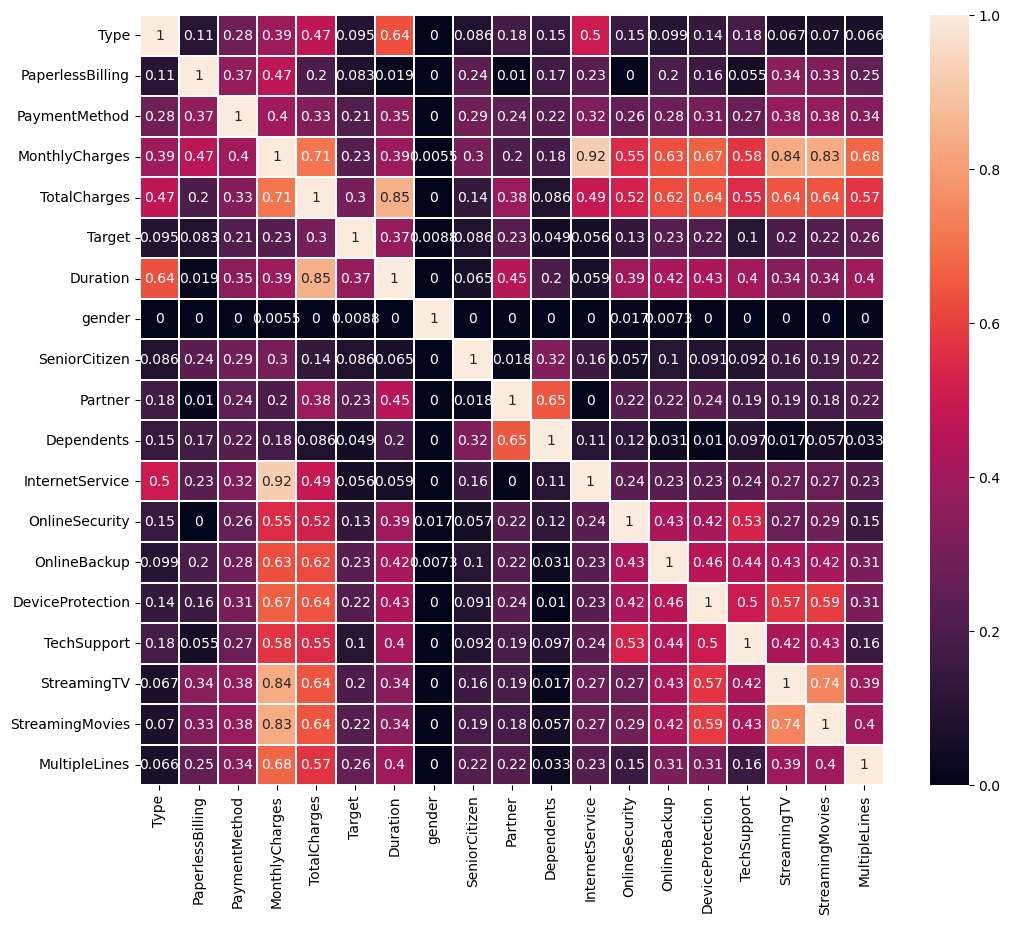

In [49]:
# Создадим список с числовыми колонками, чтобы указать их в phik_matrix
interval_cols = ['MonthlyCharges', 'TotalCharges', 'Duration']

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_full.phik_matrix(interval_cols=interval_cols), 
            annot=True, 
            linewidths=.3)

**Высокая корреляция обнаружена** у следующих колонок (corr > 0.8):  

1) TotalCharges и Duration. Уберем TotalCharges, потому что инф-я о расходах у нас есть в другой колонке, а вот колонка с длительностью контракта - уникальная и с важной информацией. Также у Duration корреляция выше с Target, чем у TotalCharges  

2) InternetService и MonthlyCharges  

3) StreamingTV и MonthlyCharges  

4) StreamingMovies и MonthlyCharges. У этой пары и пар выше уберем колонку с инф-ей о подписках. У них также корреляция с Target нижеб чем у MonthlyCharges с Target

5) Также я бы убрала колонку gender, потому что у нее нет практически никакой корреляции со всеми колонками. Она просто будет перегружать модель, но не давать ей никакой информации  

**2) Избавим от колонок с высокой корреляцией**

In [50]:
# Создадим список с названиями колонок, которые будем удалять
columns = ['TotalCharges', 'InternetService', 'StreamingTV', 'StreamingMovies', 'gender']

In [51]:
df_full = df_full.drop(columns, axis=1)

Посмотрим на 'подчищенную' матрицу корреляции

<Axes: >

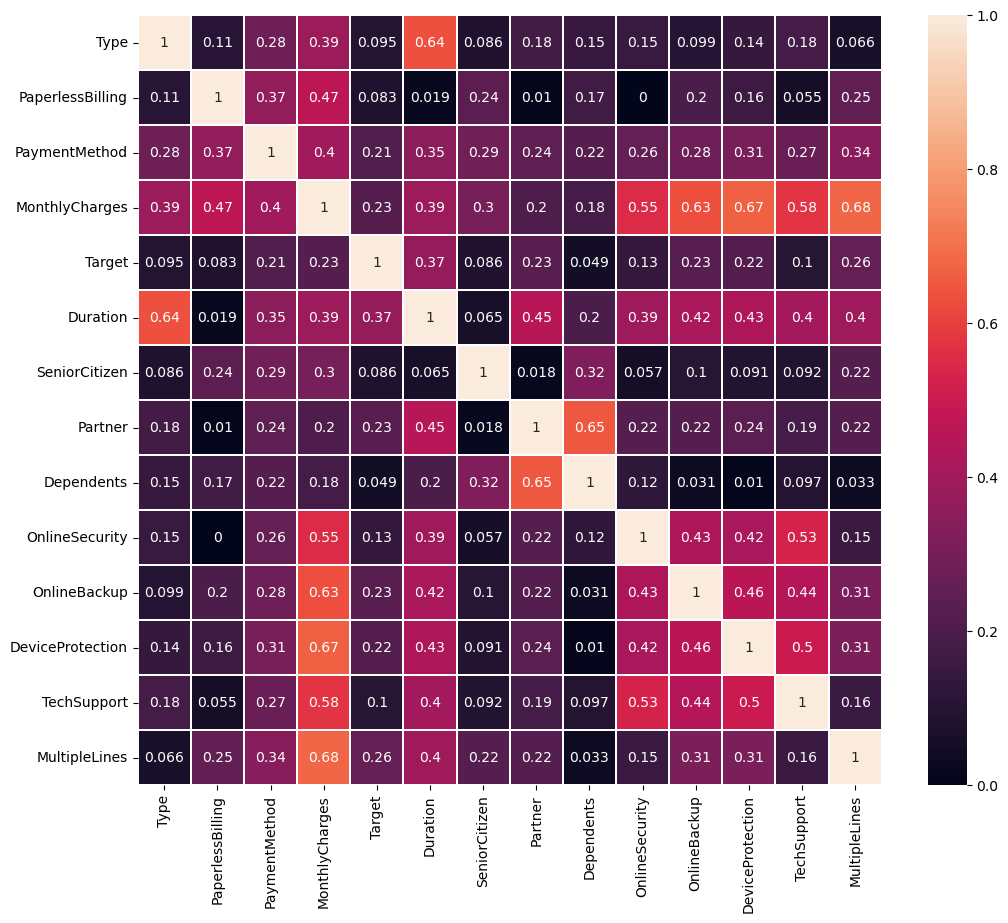

In [52]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_full.phik_matrix(interval_cols=interval_cols), 
            annot=True, 
            linewidths=.3)

**3) Изучим целевой признак**

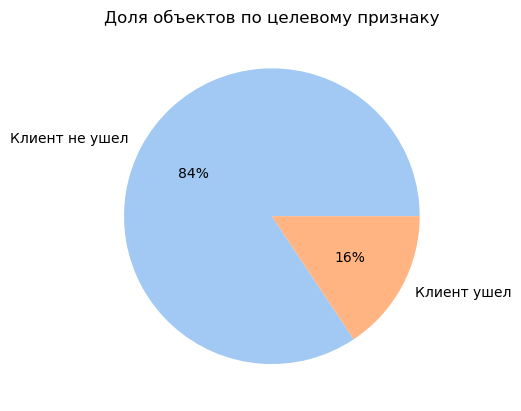

In [53]:
labels=['Клиент не ушел', 'Клиент ушел']

plt.pie(df_full['Target'].value_counts(), 
        labels=labels, 
        colors=sns.color_palette('pastel'), 
        autopct='%.0f%%')
plt.title('Доля объектов по целевому признаку')
plt.show()

**4) Изучим колонки с числовыми признаками.** У нас это:  
- MonthlyCharges - ежемесячные расходы клиента  
- Duration - длительность договора клиента

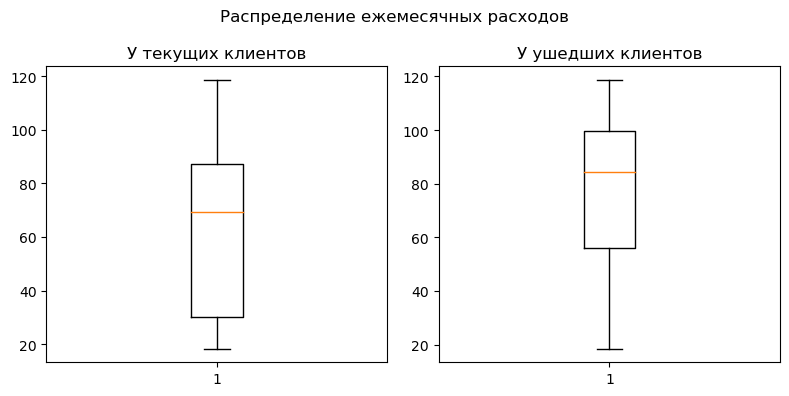

In [54]:
plt.figure(figsize=(8, 4))
plt.suptitle('Распределение ежемесячных расходов')

plt.subplot(1, 2, 1)
plt.boxplot(df_full.query('Target == 0')['MonthlyCharges'])
plt.title('У текущих клиентов')

plt.subplot(1, 2, 2)
plt.boxplot(df_full.query('Target == 1')['MonthlyCharges'])
plt.title('У ушедших клиентов')

plt.tight_layout()
plt.show()

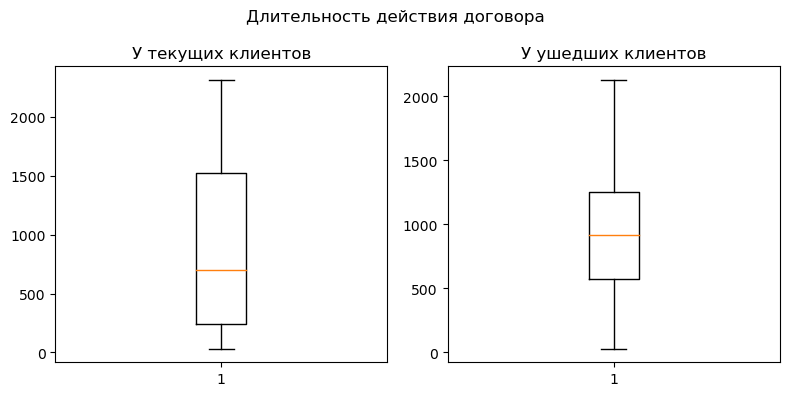

In [55]:
plt.figure(figsize=(8, 4))
plt.suptitle('Длительность действия договора')

plt.subplot(1, 2, 1)
plt.boxplot(df_full.query('Target == 0')['Duration'])
plt.title('У текущих клиентов')

plt.subplot(1, 2, 2)
plt.boxplot(df_full.query('Target == 1')['Duration'])
plt.title('У ушедших клиентов')

plt.tight_layout()
plt.show()

**5) Изучим колонки с категориальными признаками** с помощью круговой диаграммы.  

Категориальные колонки:  
- Type - тип оплаты 
- PaperlessBilling - есть ли электронный расчетный лист 
- PaymentMethod - тип оплаты  
- gender - пол клиента 
- SeniorCitizen - является ли клиент пенсионером 
- Partner - есть ли у клиента партнер  
- Dependents - есть ли у клиента дети

Создадим функцию, которая будет создавать круговые диаграммы для обеих целевых групп клиентов, получая на вход название колонки и заголовок для диаграмм.

In [56]:
def pie(column, suptitle, figsize=(8, 4)):
    
    labels1 = df_full.query('Target == 0')[column].value_counts().index.to_list()
    labels2 = df_full.query('Target == 1')[column].value_counts().index.to_list()

    plt.figure(figsize=figsize)
    plt.suptitle(suptitle)

    plt.subplot(1, 2, 1)
    plt.pie(df_full.query('Target == 0')[column].value_counts(), 
            labels=labels1, 
            colors=sns.color_palette('pastel'), 
            autopct='%.0f%%')
    plt.title('У текущих клиентов')

    plt.subplot(1, 2, 2)
    plt.pie(df_full.query('Target == 1')[column].value_counts(), 
            labels=labels2, 
            colors=sns.color_palette('pastel'), 
            autopct='%.0f%%')
    plt.title('У ушедших клиентов')


    plt.show()

Создадим пары диаграмм.

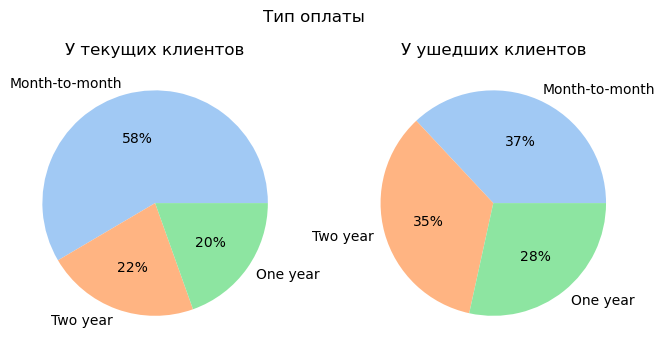

In [57]:
pie('Type', 'Тип оплаты')

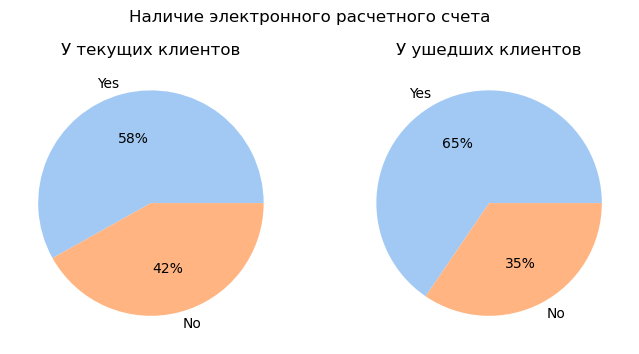

In [58]:
pie('PaperlessBilling', 'Наличие электронного расчетного счета')

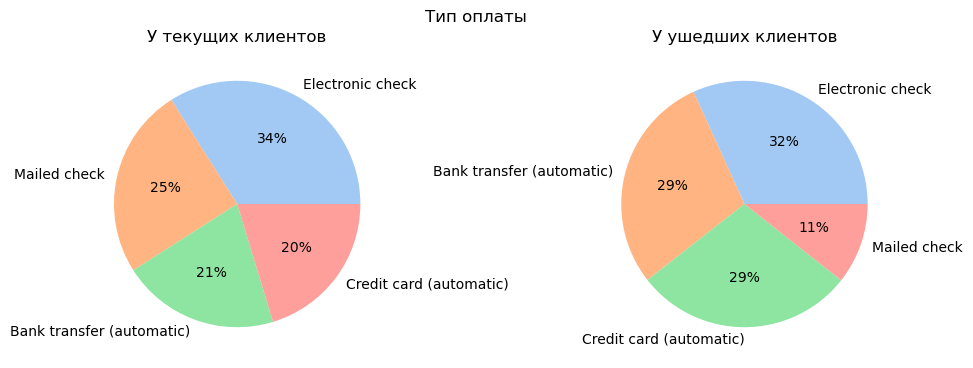

In [59]:
pie('PaymentMethod', 'Тип оплаты', (12, 4))

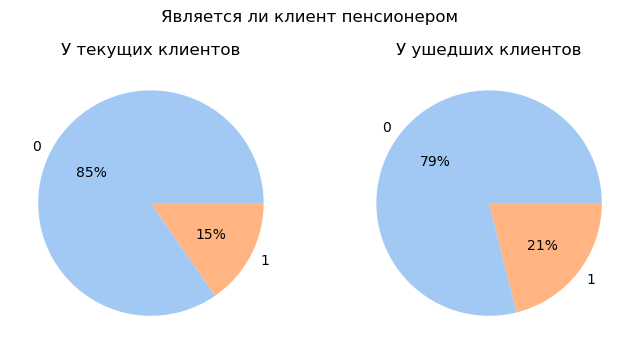

In [60]:
pie('SeniorCitizen', 'Является ли клиент пенсионером')

# 0 - нет, 1 - да

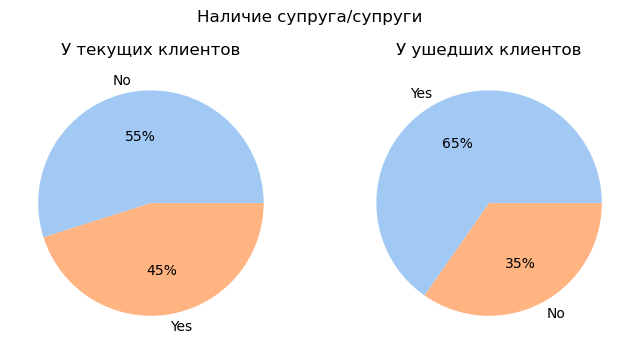

In [61]:
pie('Partner', 'Наличие супруга/супруги')

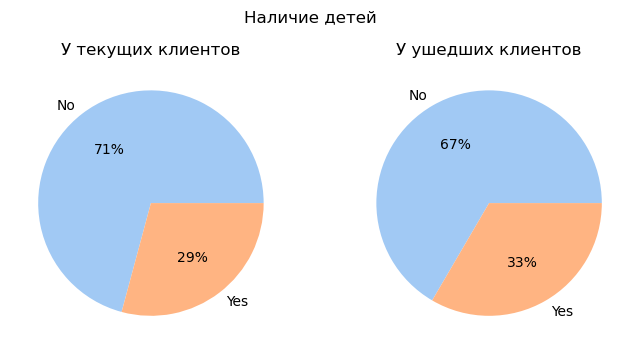

In [62]:
pie('Dependents', 'Наличие детей')

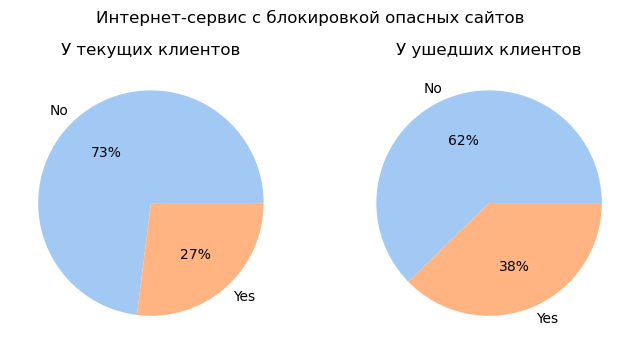

In [63]:
pie('OnlineSecurity', 'Интернет-сервис с блокировкой опасных сайтов')

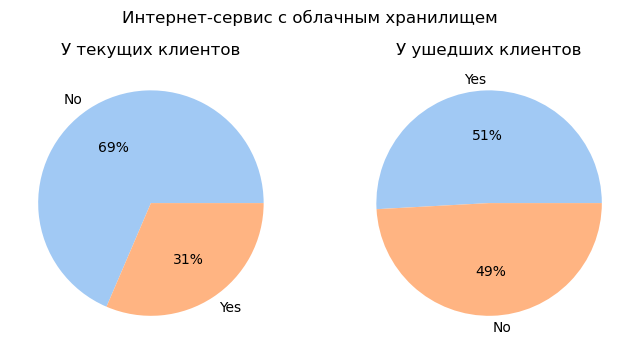

In [64]:
pie('OnlineBackup', 'Интернет-сервис с облачным хранилищем')

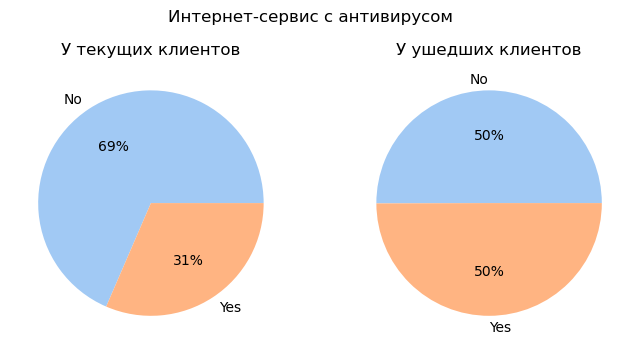

In [65]:
pie('DeviceProtection', 'Интернет-сервис с антивирусом')

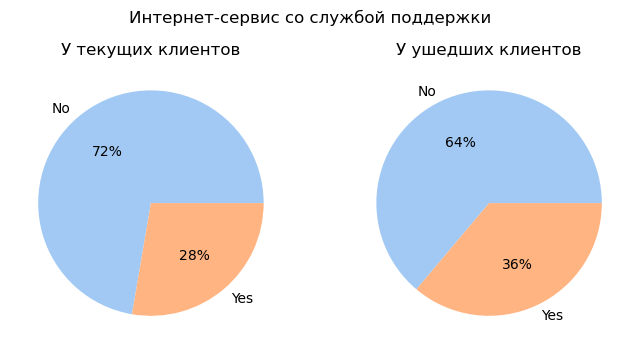

In [66]:
pie('TechSupport', 'Интернет-сервис со службой поддержки')

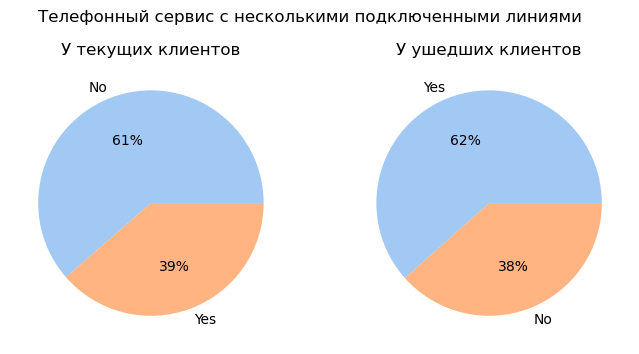

In [67]:
pie('MultipleLines', 'Телефонный сервис с несколькими подключенными линиями')

**Наблюдения:**  
1) В датасете 16% данных о клиентах, которые отказались от услуг связи.  

2) *Ежемесячные расходы.* У ушедшей группы медиана больше, чем у текущих клиентов: 90 против 70. Также межквартильный размах у ушедшей группы от 60 до 100 у.е.  

3) *Длительность договора.*  У ушедшей группы межквартильный размах меньше, чем у группы, которая осталась: 600 - 1200 против 200 - 1500. Нижняя граница у текущих объясняется тем, что в данных есть также клиенты, которые только "подключились".  

4) *Тип оплаты.* У текущих клиентов преобладает помесячный тип оплаты. У ушедших типы оплаты примерно равномерно распределены. Также может объясняться тем, что новые клиенты начинают пользоваться сервисом с помесячногй оплаты, чтобы попробовать сервис.  

5) *Наличие электронного расчетного счета.* У ушедших клиентов он чаще имеется.  

6) *Тип оплаты.* У текущих клиентов чаще тип оплаты - электронный чек, остальные типы оплаты равномерно распределены. У тех, кто ушел, реже всего встречается отправленный по почте чек, а остальные типы оплаты равномерно распределены между собой.   

7) *Пенсионеры* чаще отказываются от услуг, чем другие.  

8) *Люди в браке* также чаще отказываются от услуг.  

9) *Люди с детьми* также чаще отказываются от услуг.  

10) *Клиенты с подключенными интернет-услугами* чаще отказываются от услуг компании. Причем это касается всех видов услуг.  

11) *Подключенный телефонный сервис с несколькими линиями связи* никак не влияет на уход клиента.

## 5. Подготовка данных

В этом разделе мы только разделим данные на обучающую и тестовую выборки.  

Для модели, которой потребуется масштабирование и кодирование признаков, мы в следующем разделе сделаем пайплайн непосредственно перед самим обучением. 

**1) Зададим константу с рандом сидом** 

In [68]:
RANDOM_STATE = 301023

**2) Делим данные на обучающую и тестовую выборки**

In [69]:
# делим данные на признаки и целевой признак
x = df_full.drop('Target', axis=1)
y = df_full.Target

In [70]:
x.shape, y.shape

((7032, 13), (7032,))

In [71]:
# делим выборки на обучающую и тестовую
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=RANDOM_STATE)

In [72]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5274, 13), (1758, 13), (5274,), (1758,))

## 6. Обучение моделей

**Для обучения мы возьмем:**  
- Линейную модель LogisticRegression  
- Случайный лес RandomForestClassifier  
- Градиентный бустинг Catboost  

Нам потребуется масштабировать и закодировать признаки. Также мы подберем лучшие трансформеры и сделаем кросс-валидацию с помощью GridSearchCV.  

В catboost все эти шаги включены в модель.

**1) Модель LogisticRegression**

Создадим списки с названиями категориальных и числовых колонок

In [73]:
cat_cols = ['Type', 
            'PaperlessBilling', 
            'PaymentMethod', 
            'SeniorCitizen', 
            'Partner', 
            'Dependents',
            'OnlineSecurity',
            'OnlineBackup',
            'DeviceProtection',
            'TechSupport',
            'MultipleLines']
num_cols = ['MonthlyCharges', 'Duration']

Создадим пайплайн

In [74]:
column_transformer = make_column_transformer((StandardScaler(), num_cols),
                                             (OneHotEncoder(drop='first'), cat_cols),
                                              remainder='passthrough')

In [75]:
model = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)

In [76]:
pipeline = make_pipeline(column_transformer, model)
pipeline.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  ['MonthlyCharges', 'Duration']),
                                 ('onehotencoder', OneHotEncoder(drop='first'),
                                  ['Type', 'PaperlessBilling', 'PaymentMethod',
                                   'SeniorCitizen', 'Partner', 'Dependents',
                                   'OnlineSecurity', 'OnlineBackup',
                                   'DeviceProtection', 'TechSupport',
                                   'MultipleLines'])]),
 'logisticregression': LogisticRegression(class_weight='balanced', random_state=301023)}

Создадим параметры для ГридСерча

In [77]:
params = {
        'columntransformer__standardscaler': [StandardScaler(), MinMaxScaler()],
        'columntransformer__onehotencoder': [OneHotEncoder()]
}

In [78]:
grid = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc')

In [79]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['MonthlyCharges',
                                                                          'Duration']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'MultipleLines'])])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=301023))]),
             param_grid={'columntransformer__onehotencoder': [OneHotEncoder()],
                         'columntransformer__standardscaler': [StandardScaler(),
                                                               MinMaxScaler()]},
             scoring='roc_auc')

In [80]:
grid.best_score_

0.7451328780673473

In [81]:
grid.best_params_

{'columntransformer__onehotencoder': OneHotEncoder(),
 'columntransformer__standardscaler': MinMaxScaler()}

**Лучшие результаты модели:**  
- Roc_auc = 0.745  
- Кодировка - OneHotEncoder  
- Масштабирование - MinMaxScaler

**2) Случайный лес RandomForestClassifier**

In [82]:
model = RandomForestClassifier(n_estimators=200, 
                               max_depth=3, 
                               random_state=RANDOM_STATE)

In [83]:
pipeline = make_pipeline(column_transformer, model)
pipeline.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  ['MonthlyCharges', 'Duration']),
                                 ('onehotencoder', OneHotEncoder(drop='first'),
                                  ['Type', 'PaperlessBilling', 'PaymentMethod',
                                   'SeniorCitizen', 'Partner', 'Dependents',
                                   'OnlineSecurity', 'OnlineBackup',
                                   'DeviceProtection', 'TechSupport',
                                   'MultipleLines'])]),
 'randomforestclassifier': RandomForestClassifier(max_depth=3, n_estimators=200, random_state=301023)}

In [84]:
params = {
    'columntransformer__standardscaler': [StandardScaler(), MinMaxScaler()],
    'columntransformer__onehotencoder': [OneHotEncoder()],
    'randomforestclassifier__n_estimators': range(50, 200, 50),
    'randomforestclassifier__max_depth': range(2, 5)
}

In [85]:
grid = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc')

In [86]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['MonthlyCharges',
                                                                          'Duration']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'Dev...
                                       ('randomforestclassifier',
                                        RandomForestClassifier(max_depth=3,
                                                               n_estimators=200,
                                                               random_state=301023))]),
             param_grid={'columntransformer__onehotencoder': [OneHotEncoder()],
                         'columntransformer__standardscaler': [StandardScaler(),
                                                               MinMaxScaler()],
                         'randomforestclassifier__max_depth': range(2, 5),
                         'randomforestclassifier__n_estimators': range(50, 200, 50)},
             scoring='roc_auc')

In [87]:
grid.best_score_

0.7974918820757582

In [88]:
grid.best_params_

{'columntransformer__onehotencoder': OneHotEncoder(),
 'columntransformer__standardscaler': MinMaxScaler(),
 'randomforestclassifier__max_depth': 4,
 'randomforestclassifier__n_estimators': 150}

**Лучшие результаты модели:**  
- ROC_AUC = 0.79  
- Кодировка - OneHotEncoder  
- Масштабирование - MinMaxScaler 

**3) Градиентный бустинг CatBoost**

In [89]:
train_dataset = Pool(x_train, y_train, cat_features=cat_cols)

catboost_model = CatBoostClassifier(n_estimators=200,
                                    loss_function='Logloss',
                                    eval_metric='AUC:hints=skip_train~false',
                                    logging_level='Silent',
                                    auto_class_weights='Balanced',
                                    random_seed=RANDOM_STATE
                                   )

catboost_model.fit(train_dataset,
                   eval_set = train_dataset,
                   use_best_model = True,
                   plot = True,
                   verbose=False
                  )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [90]:
catboost_model.best_score_

{'learn': {'Logloss': 0.3007033340877116, 'AUC': 0.9619379650171394},
 'validation': {'Logloss': 0.31278928903581804, 'AUC': 0.9557387666908987}}

In [91]:
catboost_model.get_params()

{'loss_function': 'Logloss',
 'random_seed': 301023,
 'logging_level': 'Silent',
 'auto_class_weights': 'Balanced',
 'eval_metric': 'AUC:hints=skip_train~false',
 'n_estimators': 200}

**Лучшие результаты модели:**
- ROC_AUC = 0.95

**Выводы:**

Мы обучили три разные модели. Единственная, которая нам подходит по критерию Roc_auc >= 0.85 - CatBoostClassifier

## 7. Тестирование лучшей модели

Рассчитаем метрику roc_auc на тестовых данных.

In [92]:
probabilities_test = catboost_model.predict_proba(x_test)
probabilities_one_test = probabilities_test[:, 1]

print('Roc-auc:', roc_auc_score(y_test, probabilities_one_test))

Roc-auc: 0.887088214883455


Отлично! Метрика снизилась на 0.07, и наша модель подходит по критерию.   

Теперь построим roc-кривую и посмотрим наглядно, как распределились наши вероятности классов.

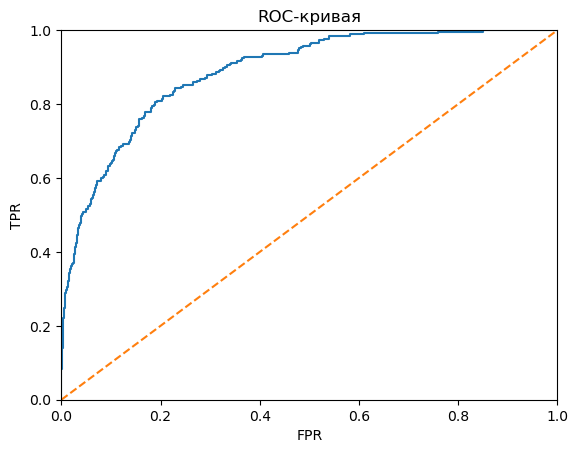

In [93]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-кривая")
plt.show()

Наша roc-кривая располагается намного выше константной модели. Значит, модель проверку на адекватность прошла.

## 8. Общий вывод и рекомендации заказчику

Мы изучили все выданные нам данные и работали в конечном итоге только с частью из них: с данными о контрактах и персональными данными.  

С помощью исследовательского анализа данных мы можем составить **общий портрет клиента, который потенциально может уйти**:  

1) Это человек, который в месяц расходует от 60 до 100 у.е. А длительность его договора составляет от 600 дней до 1200, то есть от 2 лет до 4.  

2) Клиент имеет электронный счет и чаще оплачивает либо автоматическими списаниями с любой карты, либо электронным чеком.  

3) Вероятнее всего это пенсионеры в браке с детьми.  

Также у этого клиента есть интернет-подписки, которые в свою очередь повышают ежемесячные расходы клиента.  
**Рекомендуем обратить внимание именно на этот аспект**

Также **мы обучили три модели** и подобрали для них чамые оптимальные гиперпараметры для наилучшего результата:  
- Логистическая регрессия;  
- Случайный лес;  
- CatBoost Классификатор;  

Подходящий результат нам показал **CatBoost Классификатор с гиперпараметрами**:  
- 'loss_function': 'Logloss',  
- 'logging_level': 'Silent',  
- 'auto_class_weights': 'Balanced',  
- 'eval_metric': 'AUC:hints=skip_train~false',  
- 'n_estimators': 200  

*Результат по метрике Roc_auc составил 0.89*